In [83]:
!pip install -q catboost
!pip install -q shap==0.39.0

     |████████████████████████████████| 356 kB 3.9 MB/s 


In [124]:
import pandas as pd
import numpy as np

from statistics import mean
# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import precision_recall_curve
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix

from sklearn.metrics import mean_absolute_percentage_error
from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")

#Reproducibility
import os
SEED = 2311
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [125]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
TARGET = 'Transported'

# EDA

In [126]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4346 non-null   object 
 1   HomePlanet    4258 non-null   object 
 2   CryoSleep     4240 non-null   object 
 3   Cabin         4245 non-null   object 
 4   Destination   4259 non-null   object 
 5   Age           4260 non-null   float64
 6   VIP           4237 non-null   object 
 7   RoomService   4251 non-null   float64
 8   FoodCourt     4242 non-null   float64
 9   ShoppingMall  4235 non-null   float64
 10  Spa           4265 non-null   float64
 11  VRDeck        4250 non-null   float64
 12  Name          4240 non-null   object 
 13  Transported   4346 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 445.8+ KB


In [127]:
num_columns = list(test[test.columns].select_dtypes(include=['float64']).columns)
cat_columns = list(test[test.columns].select_dtypes(include=['object']).columns)

In [128]:
missing = train.isna().sum().div(train.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing.columns  = ['% missing']
missing = missing[missing['% missing']>0]
missing

,% missing
ShoppingMall,2.554073
VIP,2.508053
CryoSleep,2.439024
Name,2.439024
FoodCourt,2.393005
Cabin,2.323976
VRDeck,2.208928
RoomService,2.185918
HomePlanet,2.024850
Destination,2.001841


**Conclustion:-** Out of 13 features, 12 have missing values  but percentage isvery less

True: 2189, False: 2157


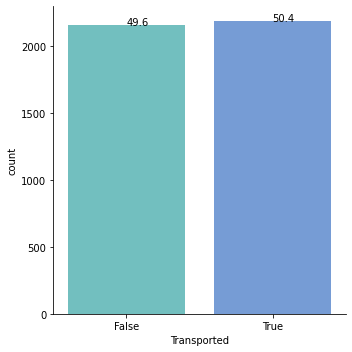

In [129]:
# Checking Target class
x = train[TARGET].value_counts().index
y = train[TARGET].value_counts()
Transported = train[train[TARGET]==True].shape[0]
Not_Transported = train[train[TARGET]==False].shape[0]
print("True: " + str(Transported) + ", False: " + str(Not_Transported))
sns.catplot(data=train, x=TARGET, kind="count", palette="winter_r", alpha=.6)
percentage = [np.round(i/len(train),3)*100 for i in train[TARGET].value_counts()]
for x, y, p in zip(x, y, percentage):
   plt.text(x, y, p)
plt.show()

**Conclustion:-** Balanced


In [130]:
train.PassengerId.nunique(), train.shape[0]

(4346, 4346)

In [131]:
train.Name.nunique(), train.shape[0]

(4235, 4346)

**Conclustion -** Both `PassengerId` and`Name` confirmed as a unique identifier. Should be dropped from feature set before modeling.

In [132]:
train.HomePlanet.value_counts()/len(train)*100

Earth     53.290382
Europa    24.436263
Mars      20.248504
Name: HomePlanet, dtype: float64

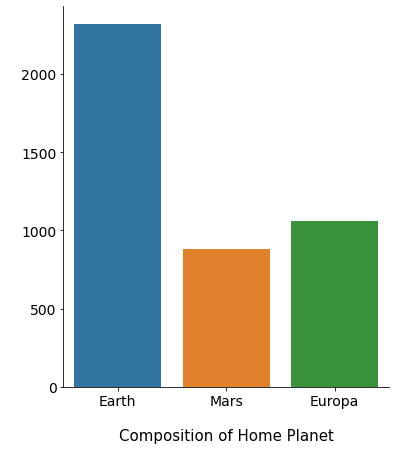

In [133]:
plt.figure(figsize=(14,7))
# barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x=train["HomePlanet"])
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(top=True, right=True)
plt.xlabel('Composition of Home Planet', fontsize=15, labelpad=20)
plt.subplots_adjust(wspace=0.4)
plt.show()

Most travellers are from

In [134]:
train.CryoSleep.value_counts()/len(train)*100

False    62.563277
True     34.997699
Name: CryoSleep, dtype: float64

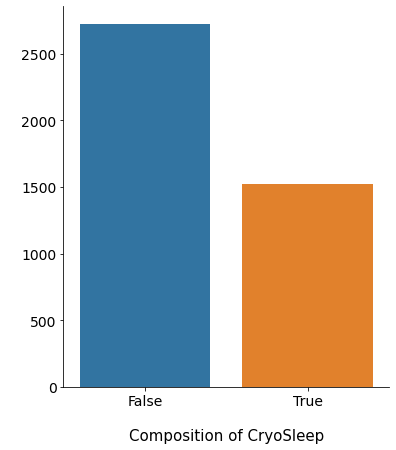

In [135]:
plt.figure(figsize=(14,7))
# barplot
ax1 = plt.subplot(1,2,1)
cp = sns.countplot(x=train["CryoSleep"])
ax1.set_xlabel(" ")
ax1.set_ylabel(" ")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.despine(top=True, right=True)
plt.xlabel('Composition of CryoSleep', fontsize=15, labelpad=20)
plt.subplots_adjust(wspace=0.4)
plt.show()

In [136]:
train.Cabin.nunique(), train.shape[0]

(3614, 4346)

**Conclusion -** High Cardinality

In [137]:
train.Destination.value_counts()/len(train)*100

TRAPPIST-1e      68.568799
55 Cancri e      20.593649
PSO J318.5-22     8.835711
Name: Destination, dtype: float64

In [138]:
train.VIP.value_counts()/len(train)*100

False    95.167971
True      2.323976
Name: VIP, dtype: float64

**Conslution-** Feature `VIP` is a quasi-constant features as they have same value for a great majority of observations in the dataset. 

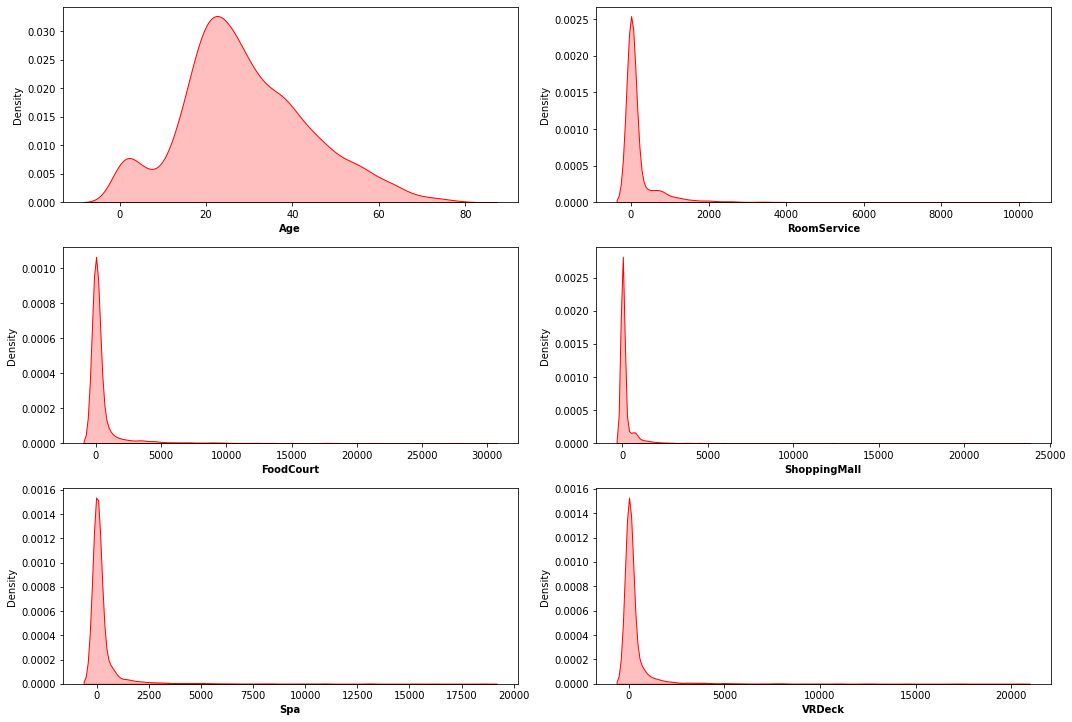

In [139]:
plt.figure(figsize=(15, 100))
for i, col in enumerate(num_columns):
    plt.subplot(30, 2, i+1)
    sns.kdeplot(train[col],color='red',shade=True)
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

In [140]:
def skew_columns(num_columns:list)->list:
    """
    will return list of features with Skewness
    """
    skewed_columns=[col for col in num_columns if(train[col].skew()>1)]
    return skewed_columns

skewed_columns = skew_columns(num_columns)
print(skewed_columns)

['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


**Conslution-** Both visualization and stastical test confirms that `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa` and `VRDeck` have skewness.

As they are left skewed, we can try `log transformation`

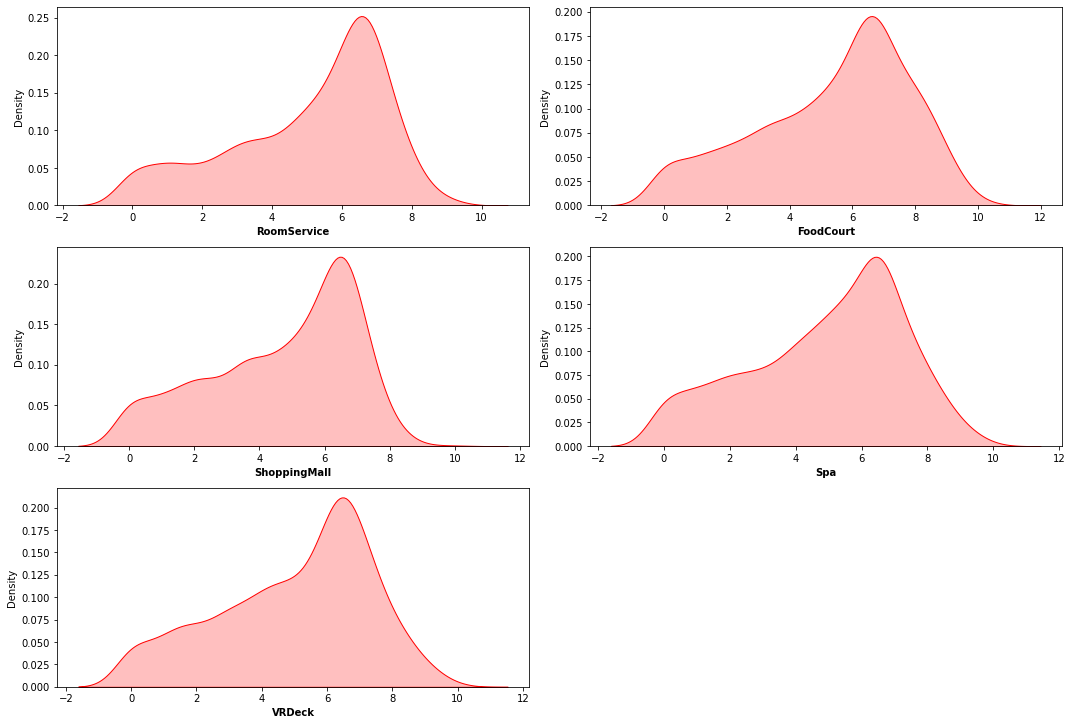

In [141]:
plt.figure(figsize=(15, 100))
for i, col in enumerate(skewed_columns):
    plt.subplot(30, 2, i+1)
    sns.kdeplot(np.log(train[col]),color='red',shade=True)
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

**Conslution-** Surly looks better

In [142]:
# Conclusion of the initial analysis
from prettytable import PrettyTable

pt=PrettyTable()
pt.field_names=["Feature","Comments","What to do?"]
pt.add_row(["PassengerId","Unique Identifier","Drop"])
pt.add_row(["HomePlanet","Looks good","-"])
pt.add_row(["CryoSleep","Looks good","-"])
pt.add_row(["Cabin","High Cardinality","Require more analysis"])
pt.add_row(["Destination","Looks good","-"])
pt.add_row(["Age","Similar to bell curve","-"])
pt.add_row(["VIP","Quasi-Constant","Require more analysis"])
pt.add_row(["RoomService","Left Skewed","log transformation or robust scalar"])
pt.add_row(["FoodCourt","Left Skewed","log transformation or robust scalar"])
pt.add_row(["ShoppingMall","Left Skewed","log transformation or robust scalar"])
pt.add_row(["Spa","Left Skewed","log transformation or robust scalar"])
pt.add_row(["VRDeck","Left Skewed","log transformation or robust scalar"])
pt.add_row(["Name","Unique Identifier","Drop"])
pt.add_row(["Transported(Response Variable)","Balanced(Looks good)","-"])
print(pt)

+--------------------------------+-----------------------+-------------------------------------+
|            Feature             |        Comments       |             What to do?             |
+--------------------------------+-----------------------+-------------------------------------+
|          PassengerId           |   Unique Identifier   |                 Drop                |
|           HomePlanet           |       Looks good      |                  -                  |
|           CryoSleep            |       Looks good      |                  -                  |
|             Cabin              |    High Cardinality   |        Require more analysis        |
|          Destination           |       Looks good      |                  -                  |
|              Age               | Similar to bell curve |                  -                  |
|              VIP               |     Quasi-Constant    |        Require more analysis        |
|          RoomService        

# Performing Feature Selection

Making a temporory dataframe then ropping all null value in it and will perform label encoding to perform feature selection.
* Mutual Information
* Checking multicollinearity
* Chisquare Test for Independence
* ANOVA F-test

In [143]:
#@title Helper
temp = train.copy()
temp.dropna(inplace=True)

for col in temp.columns:
    if temp[col].dtype == 'O':
        encoder = LabelEncoder()
        temp[col] = encoder.fit_transform(temp[col])        
    if temp[col].dtype == 'bool':
        temp[col] = temp[col].astype('int')

### Mutual Information

Mutual information is a quantity that measures a relationship between two random variables that are sampled simultaneously. It returns a non-nagative integer, which measures dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

The function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances.

Formula-

$$
I(X,y) = H(X) - H(\frac{X}{y})
$$

**where:-**
* **y** - Response variable
* **X** - Independent variable
* **I(X,y)** is the mutual information for X and y
* **H(X)** is the entropy of X
* **H(X | y)** is the conditional entropy for X given Y.

In [144]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(temp.iloc[:,:-1], temp.iloc[:,-1],random_state=SEED)
mutual_info = pd.Series(mutual_info)
mutual_info.index = temp.iloc[:,:-1].columns
mutual_info.sort_values(ascending=False)

CryoSleep       0.115167
RoomService     0.089024
Spa             0.080368
VRDeck          0.069077
FoodCourt       0.055580
ShoppingMall    0.051074
Cabin           0.029781
HomePlanet      0.025026
Age             0.024519
Destination     0.017371
Name            0.013949
PassengerId     0.000000
VIP             0.000000
dtype: float64

**Conslution-** We can drop `VIT`,`PassengerId` and `Name` features.

In [145]:
temp.drop(['VIP','PassengerId','Name'],axis=1,inplace=True)
cat_columns.remove('PassengerId')
cat_columns.remove('VIP')
cat_columns.remove('Name')

### Checking multicollinearity 

Checking of multicollinearity, it's important to check for as it creats problem in model's *interpretability* and weakens the statistical power of the model.

$$
VIF = \frac{1}{1-R^2}
$$

In [146]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.Series([variance_inflation_factor(temp[num_columns].values, i) for i in range(temp[num_columns].shape[1])], 
          index=temp[num_columns].columns)

Age             1.394890
RoomService     1.121859
FoodCourt       1.208819
ShoppingMall    1.101108
Spa             1.150279
VRDeck          1.189024
dtype: float64

**Conslution-** As variance inflation factor of all numerical features is less, so there is *no multicollinearity.*

### Chisquare Test for Independence

**Null hypothesis-**  No relationship exists between categorical feature and target.

**Alternative hypothesis-**  Relationship exists between categorical feature and target.

**p_value <0.05** means we reject null hypothesis and accept the feature while building model.


**NOTE -** Larger the **f-statistic** more statistical significance the particular feature is.

In [147]:
from sklearn.feature_selection import chi2
chi2_test=chi2(temp[cat_columns], temp[TARGET])

pd.DataFrame(
    data={
        'f-statistic': chi2_test[0], 
        'p-value': np.round(chi2_test[1],4),
        'accepted?': chi2_test[1] < 0.05
    },
    index=cat_columns
)

,f-statistic,p-value,accepted?
HomePlanet,41.985672,0.0000,True
CryoSleep,491.334583,0.0000,True
Cabin,2374.480341,0.0000,True
Destination,15.106420,0.0001,True


**Conslution-** As p_value for all the features is less than 0.05, we will select all the categorical features for model building. 

### ANOVA F-test
ANOVA ( Analysis of Variance) to select statistical significant numerical feature.


**Null hypothesis-**  Both classes in TARGET have equal variance.

**Alternative hypothesis-**  Both classes in TARGET have different variance.


**p_value <0.05** means we reject null hypothesis and accept the feature while building model.


**NOTE -** Larger the **f-statistic** more statistical significance the particular feature is.

[Reference](https://towardsdatascience.com/anova-for-feature-selection-in-machine-learning-d9305e228476)

In [148]:
anova_test = f_classif(temp[num_columns], temp[TARGET])

pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': np.round(anova_test[1],4),
        'accepted?': anova_test[1] < 0.05
    },
    index=num_columns
)

,f-statistic,p-value,accepted?
Age,32.750010,0.0000,True
RoomService,202.260429,0.0000,True
FoodCourt,7.428907,0.0065,True
ShoppingMall,0.009263,0.9233,False
Spa,170.940631,0.0000,True
VRDeck,139.805781,0.0000,True


**Conslution-** `ShoppingMall` is statistical insignificant, so we will drop the feature.

In [149]:
temp.drop('ShoppingMall',1,inplace=True)
num_columns.remove('ShoppingMall')
skewed_columns.remove('ShoppingMall')

# Pre-processing

In [150]:
# Separating independent features and dependent feature
X = pd.concat([train[num_columns], train[cat_columns]], axis=1)
y = train[TARGET]

In [151]:
# Dealing with null values
for col in X.columns:
    if(col in num_columns):
        X[col].fillna(X[col].median(), inplace=True) # median for numerical features
    elif(col in cat_columns):
        X[col].fillna(X[col].mode()[0], inplace=True)# mode for numerical features

In [152]:
# Encoding (mapping)
HomePlanet_label = {k: i for i, k in enumerate(X['HomePlanet'].unique(), 0)}
CryoSleep_label = {k: i for i, k in enumerate(X['CryoSleep'].unique(), 0)}
Cabin_label = {k: i for i, k in enumerate(X['Cabin'].unique(), 0)}
Destination_label = {k: i for i, k in enumerate(X['Destination'].unique(), 0)}

In [153]:
# Implimenting encoding
X['HomePlanet'] = X['HomePlanet'].map(HomePlanet_label)
X['CryoSleep'] = X['CryoSleep'].map(CryoSleep_label)
X['Cabin'] = X['Cabin'].map(Cabin_label)
X['Destination'] = X['Destination'].map(Destination_label)

In [154]:
# Target mapping
mapping = {False: 0, True: 1}
rev_mapping = {v: k for k, v in mapping.items()}
y = y.map(mapping)

Applying log transformation on the following features as decided. There are 0 values in those columns and log of 0 to inifnite,so addeding 0.1 to avoid getting infinity.


In [155]:
X['RoomService'] = X['RoomService'] + 0.1
X['FoodCourt'] = X['FoodCourt'] + 0.1
X['Spa'] = X['Spa'] + 0.01
X['VRDeck'] = X['VRDeck'] + 0.1

In [156]:
# log transformation
for col in skewed_columns:
  X[col] = np.log(X[col])

In [157]:
# Feature Scaling
scaler = RobustScaler()
scaler.fit(X[num_columns])

X_scaled = scaler.transform(X[num_columns])
X_scaled = np.c_[X_scaled,X[cat_columns]]
X_scaled.shape

(4346, 9)

# Model Testing

In [163]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [164]:
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''

    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)

        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)


        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        accuracy_list.append(model_test_accuracy)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list)), columns=['Model Name', 'TestAccuracy']).sort_values(by=["TestAccuracy"],ascending=False)
        
    return report

In [165]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [166]:
# Feature Scaling

scaler = StandardScaler()
scaler.fit(X[num_columns])

X_scaled = scaler.transform(X[num_columns])
X_scaled = np.c_[X_scaled,X[cat_columns]]
X_scaled.shape

(4346, 9)

In [167]:
evaluate_models(X_scaled, y, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9997
- F1 score: 0.9997
- Precision: 0.9994
- Recall: 1.0000
- Roc Auc Score: 0.9997
----------------------------------
Model performance for Test set
- Accuracy: 0.7621
- F1 score: 0.7618
- Precision: 0.7807
- Recall: 0.7438
- Roc Auc Score: 0.7625


Decision Tree
Model performance for Training set
- Accuracy: 0.9997
- F1 score: 0.9997
- Precision: 1.0000
- Recall: 0.9994
- Roc Auc Score: 0.9997
----------------------------------
Model performance for Test set
- Accuracy: 0.7207
- F1 score: 0.7279
- Precision: 0.7254
- Recall: 0.7303
- Roc Auc Score: 0.7205


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8167
- F1 score: 0.8231
- Precision: 0.7981
- Recall: 0.8498
- Roc Auc Score: 0.8166
----------------------------------
Model performance for Test set
- Accuracy: 0.7839
- F1 score: 0.7970
- Precision: 0.7672
- Recall: 0.8292
- Roc Auc Score: 0.7828


Logistic Regression
Model performance for Training 

,Model Name,TestAccuracy
2,Gradient Boosting,0.783908
5,XGBClassifier,0.779310
6,CatBoosting Classifier,0.779310
7,AdaBoost Classifier,0.779310
3,Logistic Regression,0.765517
0,Random Forest,0.762069
1,Decision Tree,0.720690
4,K-Neighbors Classifier,0.573563


# Final Model

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [169]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,random_state=SEED)
clf.fit(X_train, y_train)

GradientBoostingClassifier(random_state=2311)

# Model Evaluation

In [170]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7839080459770115

In [171]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77       425
           1       0.77      0.83      0.80       445

    accuracy                           0.78       870
   macro avg       0.79      0.78      0.78       870
weighted avg       0.79      0.78      0.78       870



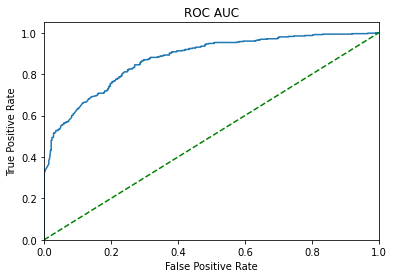

In [172]:
# ROC CURVE

clf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label = 'AUC (area = %0.2f)' % clf_roc_auc)
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.show()

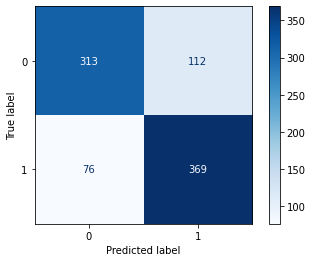

In [173]:
# Confusion Matrix

plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', values_format='d')

Text(0, 0.5, 'Precision/Recall')

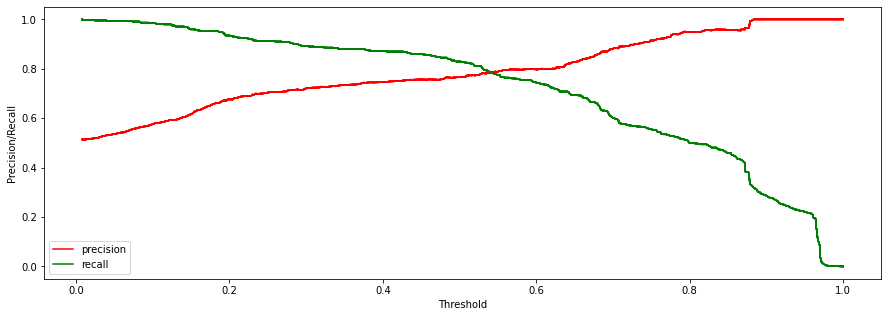

In [174]:
# Precison Variance Tradeoff
trail = 10
plot = []
for x in range(0,trail):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    clf.fit(X_train,y_train)
    pred = clf.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, pred)
    thresholds = np.append(thresholds,1)
        
    plot.append({'threshold': thresholds, 'precision':precision,'recall': recall})
plt.figure(figsize=(15,5))
for x in plot:
    plt.plot(x['threshold'],x['precision'],'r')
    plt.plot(x['threshold'],x['recall'],'g')
    
plt.legend(('precision','recall'))
plt.xlabel('Threshold')
plt.ylabel("Precision/Recall")

# Explainable AI using SHAP
GradientBoostingClassifier is a blackbox model i.e. difficult to interpret. So now I will be using `SHAP(SHapley Additive exPlanations)`, to understand on what basis is model making prediction. Explainable AI is like performing EDA on model. Using this we try to understand how the model landed on particular predictions.

In [175]:
import shap
shap.initjs()

In [176]:
shap_values = shap.TreeExplainer(clf).shap_values(X_train)

In [177]:
shap.initjs()
shap.force_plot(shap.TreeExplainer(clf).expected_value[0], shap_values[:1000,:], X_train.iloc[:1000,:])

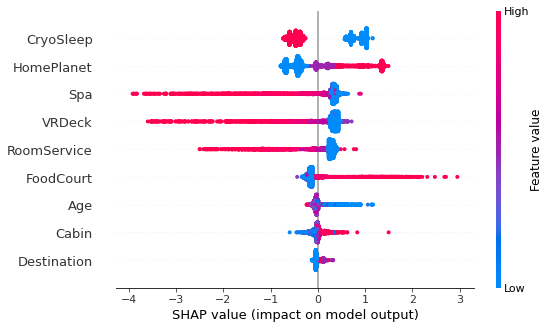

In [178]:
shap.summary_plot(shap_values, X_train)

In [180]:
print(CryoSleep_label)
print(HomePlanet_label)
print(Destination_label)

{True: 0, False: 1}
{'Earth': 0, 'Mars': 1, 'Europa': 2}
{'TRAPPIST-1e': 0, '55 Cancri e': 1, 'PSO J318.5-22': 2}


**Conclusions**



*   **CryoSleep** is the most important feature according to the model
*   When **CryoSleep** is `True` model is more inclined towards predicting True class
*   If the travellers is from `Europa` model is more inclined towards predicting True class, travellers `Mars` don't contribute in predicting, while for travellers from `earth` model is more inclined towards predicting False class.
*   Model is more inclined towards predicting False class for travellers who spend more on luxury amenities like **RoomService**,  **Spa** and **VRDeck**
*   The case **FoodCourt** is exactly opposite, model is more inclined towards predicting True class if travellers spend more here.





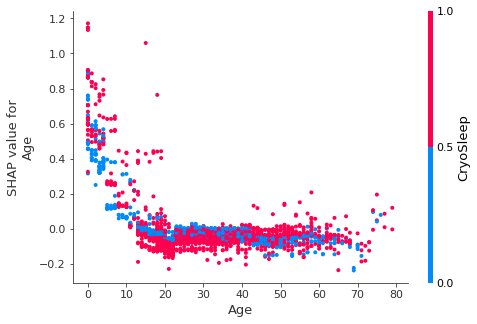

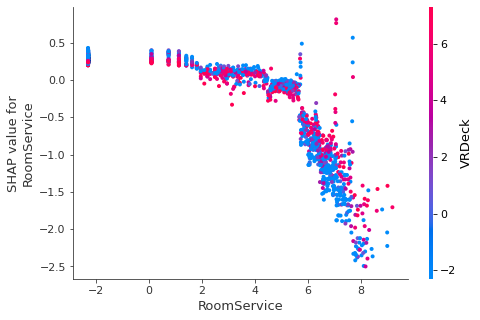

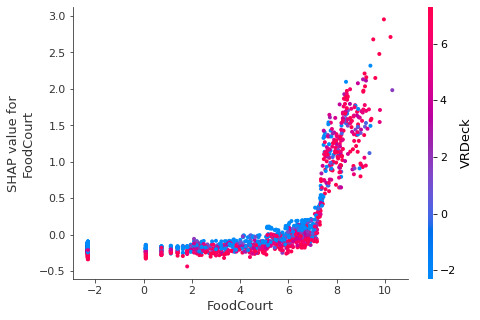

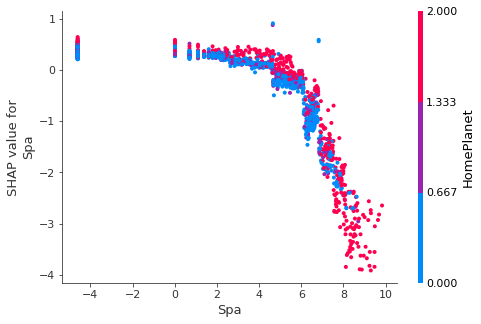

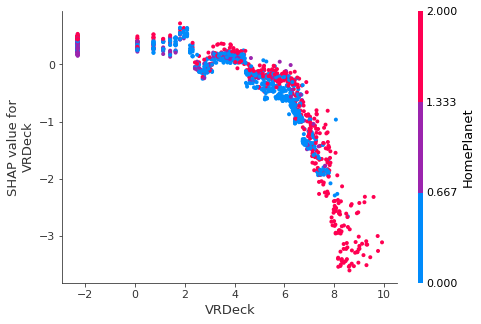

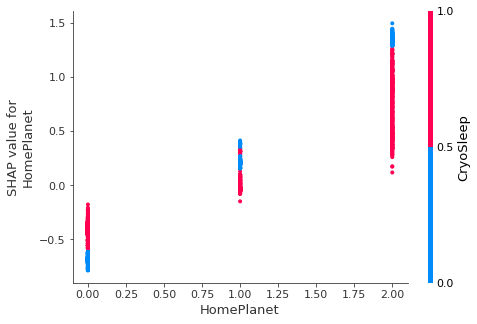

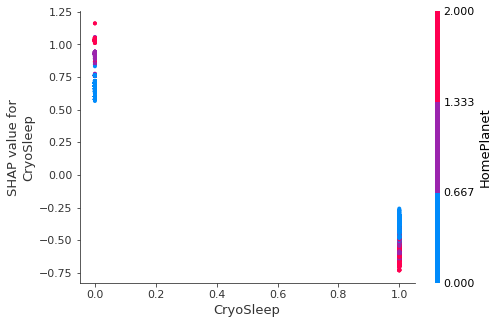

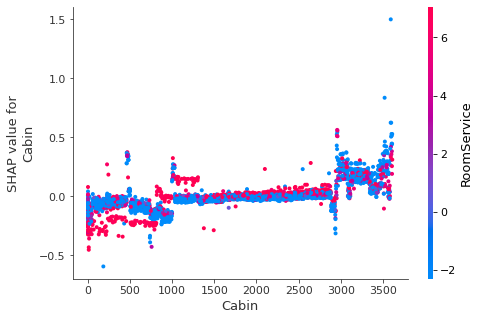

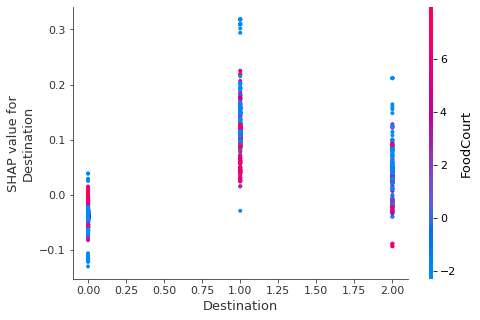

In [181]:
shap.initjs()
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train)